# Ch 05: Pretraining on Unlabeled Data

이번 챕터에서는 모델을 직접 빌드하고 학습 loop를 만드는 것을 실습함

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.1.3
tiktoken version: 0.9.0
torch version: 2.6.0
tensorflow version: 2.19.0


# 5.1: Evaluating generative text models

LLM 모델을 먼저 생성해 보고 생성된 text를 평가하는 식으로 진행

In [2]:
from ch05 import GPTModel, GPT_124M_CONFIG

In [3]:
import torch

MODEL_CONFIG = GPT_124M_CONFIG
# for training
MODEL_CONFIG.max_context_length = 256

torch.manual_seed(123)
model = GPTModel(MODEL_CONFIG)
model.eval();  # Disable dropout during inference

In [4]:
import tiktoken
from ch05 import generate_text_simple

In [9]:
model_device = torch.device("mps")

In [8]:
def text_to_token_ids(text, tokenizer, device):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded, device=device).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [10]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

In [12]:
import time

start_time = time.time()
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer, device=torch.device("cpu")),
    max_new_tokens=10,
    context_size=MODEL_CONFIG.max_context_length
)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Time taken: 0.7376508712768555 seconds
Output text:
 Every effort moves youochondabol Brig sensibilities praise relativelyopia principalsT revital


이건 그냥 apple silicon으로 했을 때 얼마나 빠른지 실험

In [14]:
import torch

# Check if MPS is available
# https://pytorch.org/docs/stable/notes/mps.html
print(torch.backends.mps.is_available())

# Move model to MPS device
model = model.to('mps')

# Generate text with MPS
start_time = time.time()
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer, device=model_device),
    max_new_tokens=10,
    context_size=MODEL_CONFIG.max_context_length
)
end_time = time.time()
print(f"Time taken with MPS: {end_time - start_time} seconds")

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


True
Time taken with MPS: 0.27061986923217773 seconds
Output text:
 Every effort moves youochondabol Brig sensibilities praise relativelyopia principalsT revital


여기서 보게 되면 text가 불안정한 것을 볼 수 있다.
그렇다면 좋은 텍스트라는 건 어떻게 정의할 수 있는 것인가?? 그것도 수학적으로 정의를 해야 한다.

이후 챕터에서 loss를 구하고 metric을 정의하고 이를 training 과정에서 사용할 예정이다.

# 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

text generation loss를 계산을 하여 학습을 할 예정

![step](images/2025-04-13-14-14-37.png)

In [15]:
inputs = torch.tensor(
    [
        [16833, 3626, 6100], # "every effort moves"
        [40, 1107, 588]      # "I really like"
    ],
    device=model_device
)  

targets = torch.tensor(
    [
        [3626, 6100, 345],   # " effort moves you",
        [1107, 588, 11311],  # " really like chocolate"
    ],
    device=model_device
)

In [16]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [17]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[25495],
         [25829],
         [31926]],

        [[ 6092],
         [33964],
         [43293]]], device='mps:0')


In [18]:
print(f"Inputs batch 1: {token_ids_to_text(inputs[0], tokenizer)}")
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Inputs batch 1: every effort moves
Targets batch 1:  effort moves you
Outputs batch 1:  punches 275 Hunts


모델이 아직 학습되지 않아 target과 일치하지는 않습니다. 그렇다면 이걸 target과 일치하기 위해서는 어떻게 해야 할까요?

target token과 output token이 서로 얼마나 떨어져 있는지 계산하면 된다.

![prob](images/2025-04-13-15-22-05.png)

그래서 최대한 target token의 prob를 높이는게 목표

In [19]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2] , targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([1.7986e-05, 7.4042e-06, 2.7640e-05], device='mps:0')
Text 2: tensor([1.5521e-05, 9.4126e-06, 1.1893e-05], device='mps:0')


즉 위 target_probas 값을 최대화를 해서 다른 토큰이 선택 되지 않도록 하는게 목표이다.

이를 수학적으로 loss를 구하는 방법은 [logistic regression](https://www.youtube.com/watch?v=GxJe0DZvydM) 이다.

In [20]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.9259, -11.8135, -10.4962, -11.0733, -11.5735, -11.3396],
       device='mps:0')


In [21]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-11.2037, device='mps:0')


이제 값을 최대한 최대치로 만드는 게 목표이다. 지금은 log를 취해서 만들어 졌기 때문에 취할 수 있는 최대 값은 0이다.

확률 변수 X라고 했을 때 sum(prob(X)) = 1.0, log(sum(prob(x))) = 0.0

In [22]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(11.2037, device='mps:0')


In [23]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [24]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [25]:
# cross entropy: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

# input: [B, C], target: [C] -> target value: [0, C) (class id)
# input: [B, C], target: [B, C] -> target value: [0, 1] (probability)
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(11.2037, device='mps:0')


perplexity를 구합니다. 이 값은 단순히 cross entropy값을 exp를 한 값입니다. 

이 값은 각 step별로 확실하지 않는(?)(uncertain) vocab size 차이를 알아내기에 유용해서 쓰입니다. 
```
Entropy measures the expected or "average" number of bits required to encode the outcome of the random variable using an optimal variable-length code. It can also be regarded as the expected information gain from learning the outcome of the random variable, providing insight into the uncertainty and complexity of the underlying probability distribution.
```
![](images/2025-04-13-19-18-53.png)
![](images/2025-04-13-19-24-03.png)

In [26]:
# https://en.wikipedia.org/wiki/Perplexity

perplexity = torch.exp(loss)
print(perplexity)

tensor(73399.2891, device='mps:0')


entropy 수식

![](images/2025-04-13-16-25-53.png)

실제 분포 q에 대한 모델링 p에 대한 엔트로피

![](images/2025-04-13-16-26-05.png)

kl divergence: 실제 분포와 모데링 분포가 얼마나 다른지 보여주는 지표

![](images/2025-04-13-16-26-19.png)

이 지표를 지표를 최소화하는 개 딥러닝 모델의 목적 H_q 가 고정 이므로 H_p_q를 최소하는 게 목표

# 5.1.3 Calculating the training and validation set losses

이제 실제 trainig 시작

In [27]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [28]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [29]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [30]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [31]:
from ch05 import create_dataloader_v1

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=MODEL_CONFIG.max_context_length,
    stride=MODEL_CONFIG.max_context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=MODEL_CONFIG.max_context_length,
    stride=MODEL_CONFIG.max_context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [32]:
# Sanity check

if total_tokens * (train_ratio) < MODEL_CONFIG.max_context_length:
    print("Not enough tokens for the training loader. "
          "Try to lower the `MODEL_CONFIG.max_context_length` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < MODEL_CONFIG.max_context_length:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `MODEL_CONFIG.max_context_length` or "
          "decrease the `training_ratio`")

In [33]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [34]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [35]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [36]:
model.to(model_device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, model_device)
    val_loss = calc_loss_loader(val_loader, model, model_device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98398568895128
Validation loss: 11.035062789916992


# 5.2:  Training an LLM

In [38]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer, device=device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [39]:
torch.manual_seed(123)
model = GPTModel(GPT_124M_CONFIG)
model.to(model_device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, model_device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.797, Val loss 10.843
Ep 1 (Step 000005): Train loss 9.964, Val loss 10.052
Every effort moves youededededededededededededededededededed-ededededededededededededededededededed-ededededededed-eded
Ep 2 (Step 000010): Train loss 8.255, Val loss 8.527
Ep 2 (Step 000015): Train loss 7.085, Val loss 7.421
Every effort moves you,-,,,-,-,,-,,-,--,,---,-,,-,-,,,,,,,----,----,--,--
Ep 3 (Step 000020): Train loss 6.477, Val loss 6.894
Ep 3 (Step 000025): Train loss 6.149, Val loss 6.688
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 4 (Step 000030): Train loss 6.084, Val loss 6.654
Ep 4 (Step 000035): Train loss 6.092, Val loss 6.717
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 5 (Step 000040): Train loss 6.038, Val loss 6.752
Every effort moves you                                                  
Ep 6 (Step 000045): Train loss 6.039, Val loss 6.753
Ep 6 (Step 000050): Train loss 6.035, Val loss 6.770
E

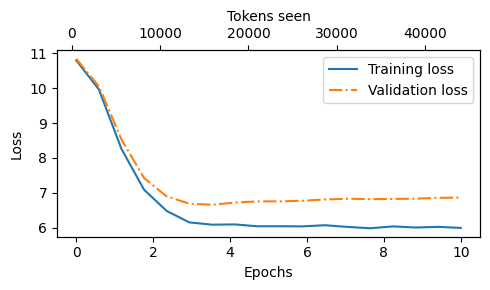

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# 5.3 Decoding strategies to control randomness

In [43]:
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer, device=model_device),
    max_new_tokens=25,
    context_size=GPT_124M_CONFIG.max_context_length
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you,,,,,,,,
,
,,,,,,,
,
,,
,


매번 같은 답변이 나오는데 이를 보완할 장치가 몇가지 있음
- temperature scaling, top k scailing 

# 5.3.1 Temperature scaling

In [44]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [45]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [46]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


temperature는 logit을 나누는 값에 불가함
- 1.0 < temperature: 확률을 더 균등하게 만듬
- 1.0 > temperature: 분포가 좀 더 가파르게 만듬

In [47]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

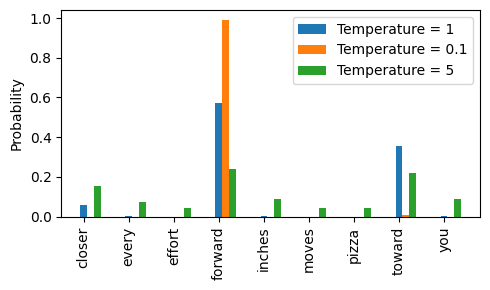

In [48]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [49]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [50]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


# 5.3.2 Top-k sampling

logit 값들 중에 가장 높은 값 k개를 취하고 나머지는 -inf를 주어서 극단적인 확률 분포를 취하는 방식

In [51]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [52]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [53]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


# 5.3.3 Modifying the text generation function

이제 decoding 전략 까지 포함해서 해보자 

In [54]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [56]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer, device=model_device),
    max_new_tokens=15,
    context_size=GPT_124M_CONFIG.max_context_length,
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you,---- he- of
 had in of"'s the and"


In [61]:
torch.save(model.state_dict(), "model.pth")

In [62]:
model = GPTModel(MODEL_CONFIG)
model.load_state_dict(torch.load("model.pth", map_location=model_device, weights_only=True))
model.eval();

In [63]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [65]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(MODEL_CONFIG)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# 5.5 Loading pretrained weights from OpenAI

여기는 실제 모델 가져와서 하는 건데 용량 문제 있을까봐 일부러 안했습니다.